## Predicting a Successful New York Times Article Comment

IPython Process Book

Welcome! Below you will find our iPython process book for our AC209 final project. This process book details our steps in developing our solution, how we collected the data, statistical methods we used, and the insights we found. This process book describes and documents what we explored at each step of our project. Specifically, this process book follows the following topics:


<strong>Overview and Motivation</strong>: Provide an overview of the project goals and the motivation for it. Consider that this will be read by people who did not see your project proposal.

<strong>Related Work</strong>: Anything that inspired you, such as a paper, a web site, or something we discussed in class.

<strong>Initial Questions</strong>: What questions are you trying to answer? How did these questions evolve over the course of the project? What new questions did you consider in the course of your analysis?

<strong>Data</strong>: Source, scraping method, cleanup, storage, etc.

<strong>Exploratory Data Analysis</strong>: What visualizations did you use to look at your data in different ways? What are the different statistical methods you considered? Justify the decisions you made, and show any major changes to your ideas. How did you reach these conclusions?

<strong>Final Analysis</strong>: What did you learn about the data? How did you answer the questions? How can you justify your answers?

<strong>Presentation</strong>: Present your final results in a compelling and engaging way using text, visualizations, images, and videos on your project web site.

# Overview and Motivation

As one of the most popular online news entities*, The New York Times (NYT) attracts thousands of unique visitors each day to its website, nytimes.com. Users who visit the site can provide their thoughts and reactions to published content in the form of comments. 

Users can interact with published comments, by either replying back or recommending a comment (i.e., similar to a 'like' on Facebook) as high quality. The very best comments are picked by NYT staff and marked as NYT picks. We noticed that highly recommended comments and NYT picks comments tend to be significantly longer, more thoughtful, and of high quality compared to the majority of other internet comments.

We aim to examine the relationship between comment success (i.e., number of recommendations by other users and if selected as a NYT pick) and various features of the comment itself. This way, we will be able to produce a model that can predict the success of a given comment. This is important as the comment section enables visitors to further interact with NYT content as it can act as a forum for the exchange of ideas, thoughts, and opinions. 

Successful comments can become more visible on the site. Thus, understanding what could make a succesfful comment is important for both content providers and commentors. Providers can provide better comment guidelines and suggestions to its audience in an attempt to increase the quality of content exchanged on message boards. Additionally, since a NYT moderator must manually approve or reject each submitted comment, a provisional comment ranking system could enable a quicker means to approve good comments. An effective prediction system could also be used in an automated comment recommender to help steer users toward higher quality content. 

*http://www.journalism.org/media-indicators/digital-top-50-online-news-entities-2015/

# Related Work

We are all avid readers of the New York Times and find the comment section to be a great launching pad for further discussion and debate. Andrew was on the leadership board of The Harvard Crimson, so he has experienced journalism first-hand.

While we have not encountered any work that specifically looks at what makes a successful comment on a news site such as that of the NYT, our work is built upon methods that are not new. Speciifcally, we aim to employ sentiment analysis and latent dirichlet allocation (LDA) in our analysis. 

Insert summary and link to a sentiment analysis paper

http://www.cs.columbia.edu/~julia/papers/Agarwaletal11.pdf

http://www.cs.cornell.edu/home/llee/papers/cutsent.pdf

Insert summary and link to LDA paper

https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf

http://ai.stanford.edu/~ang/papers/nips01-lda.pdf



# Initial Questions

Our main goal is to predict how many recommendations a comment it will receive and if it will be designated as a NYT pick based on the comment's text. Additionally, we aim to quantitatively examine what makes a successful and highly rated comment. For example, do longer comments fare better? Does average word or sentence length play a role? Does the sentiment of the comment have an effect?



# Data

We obtained the comment data from the New York Times' API. The API is well-documented and operates similar to that of the Huffington Post API that was used earlier in the course. We gathered 300 comments per day from Nov 1, 2014 to Nov 15, 2015. 

In [13]:
from datetime import date, datetime, timedelta
import requests, time, simplejson, sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

In [ ]:
# Scrape 300 comments per day from Nov. 1, 2014 to Oct. 31, 2015
for da in perdelta(date(2015, 2, 21), date(2015, 11, 1), timedelta(days=1)):
    comments = []
    print da
    skip = False
    gotany = True
    for i in range(12): # collect 25 comments at a time for 12 times. 25*12 = 300 comments
        if not skip:
            success = False
            count = 0
            url = ('http://api.nytimes.com/svc/community/v3/user-content/' +
                   'by-date.json?api-key=KEY&date=' + str(da) +
                   '&offset=' + str(25*i))
            while not success:
                comments_data = requests.get(url)
                try:
                    data = simplejson.loads(comments_data.content)
                    success = True # go to the next offset
                    for d in data['results']['comments']:
                        comments.append(d)
                    time.sleep(2)
                except:
                    print 'error on {}'.format(str(da))
                    print url
                    count += 1
                    if count > 3:
                        success = True # not really
                        skip = True # just skip to the next day
                        if i == 0:
                            gotany = False # if we didn't get any comments from that day
                    time.sleep(2)
    if gotany:      
        filestr = 'comments {}.json'.format(str(da))
        with open(filestr, 'w') as f:
            simplejson.dump(comments, f)

In [14]:
# Combine all the JSON lists into single JSON file
allcomments = []
for d in perdelta(date(2014, 1, 1), date(2015, 12, 31), timedelta(days=1)):
    try:
        with open('json_files/comments {}.json'.format(str(d))) as f:
            c = simplejson.load(f)
            allcomments.extend(c)
    except:
        pass

In [15]:
#load the aggregated JSON file
with open ('comment_data.json', 'w') as f:
    simplejson.dump(allcomments, f)
with open ('comment_data.json', 'r') as f:
    comments = simplejson.load(f)

In [30]:
#Convert data into a dataframe 
commentsdicts=[]
for c in comments:
    d={}
    d['approveDate']=c['approveDate']
    d['assetID']=c['assetID']
    d['assetURL']=c['assetURL']
    d['commentBody']=c['commentBody']
    d['commentLength'] = len(c['commentBody'].split(" "))
    d['commentID']=c['commentID']
    d['commentSequence']=c['commentSequence']
    d['commentTitle']=c['commentTitle']
    d['createDate']=c['createDate']
    d['editorsSelection']=c['editorsSelection']
    d['lft']=c['lft']
    d['parentID']=c['parentID']
    d['recommendationCount']=c['recommendationCount']
    d['replies']=c['replies']
    d['replyCount']=c['replyCount']
    d['rgt']=c['rgt']
    d['status']=c['status']
    d['statusID']=c['statusID']    
    d['updateDate']=c['updateDate']        
    d['userDisplayName']=c['userDisplayName']
    d['userID']=c['userID']
    d['userLocation']=c['userLocation']
    #d['userTitle']=c['userTitle']
    #d['userURL']=c['userURL']    
    commentsdicts.append(d)  
commentsdf=pd.DataFrame(commentsdicts)

#  Exploratory Analysis

The first thing we did in our exploratory analysis was to call the describe method to get an initial read on what we were working with. From the below, we can see that we have ~180,000 comments, where the average comment is approximatley 83 words in length. In terms of recommendation count, we see that the average comment receives 24 recommendations and the maximum number of recommendations received by any single comment was 3064. With respect to the editors selection designation, a binary indicator, we see that the mean is 0.026, which implies that just under 3% of our comments receive the editors selection designation.  

#### Describe the data

In [19]:
#describe the recommendation count data
commentsdf["recommendationCount"].describe()

count    179650.000000
mean         23.737050
std          75.944896
min           0.000000
25%           1.000000
50%           5.000000
75%          16.000000
max        3064.000000
Name: recommendationCount, dtype: float64

In [71]:
#describe the editor selection data
commentsdf["editorsSelection"].describe()

count    179650.000000
mean          0.026680
std           0.161146
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: editorsSelection, dtype: float64

In [31]:
#describe the comment word count data
commentsdf["commentLength"].describe()

count    179650.000000
mean         82.918703
std          68.293207
min           1.000000
25%          30.000000
50%          62.000000
75%         116.000000
max         767.000000
Name: commentLength, dtype: float64

#### Plot Histograms

Next we plotted several histograms to gain a better underestanding of the data. The plots support the information above, where 75% of of comments have 16 or fewer comments.

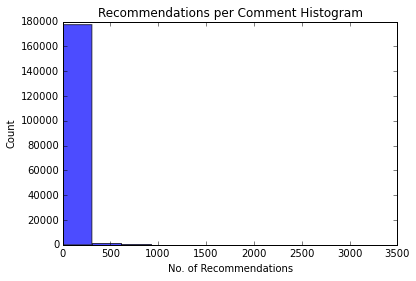

In [65]:
plt.hist(commentsdf["recommendationCount"],alpha = .7)
plt.title("Recommendations per Comment Histogram")
plt.ylabel("Count")
plt.xlabel("No. of Recommendations")
plt.show()

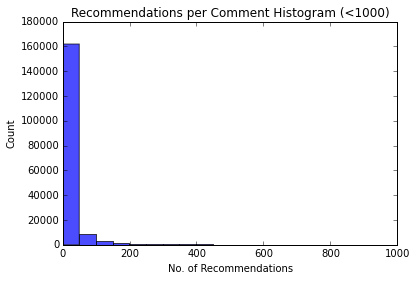

In [72]:
focusedDf = commentsdf[commentsdf["recommendationCount"] < 1000]
plt.hist(focusedDf.recommendationCount, bins=20, alpha = .7)
plt.title("Recommendations per Comment Histogram (<1000)")
plt.ylabel("Count")
plt.xlabel("No. of Recommendations")
plt.show()

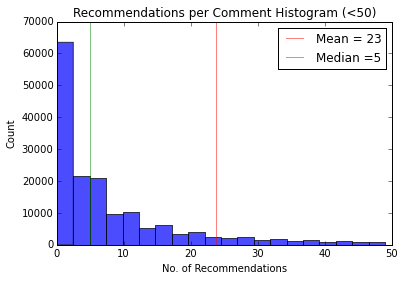

In [74]:
focusedDf = commentsdf[commentsdf["recommendationCount"] < 50]
plt.hist(focusedDf.recommendationCount, bins=20,alpha=.7)
plt.axvline(23.73,color = 'r',alpha = .5,label = 'Mean = 23')
plt.axvline(5,color = 'g',alpha = .5,label = 'Median =5')
plt.title("Recommendations per Comment Histogram (<50)")
plt.ylabel("Count")
plt.xlabel("No. of Recommendations")
plt.legend()
plt.show()

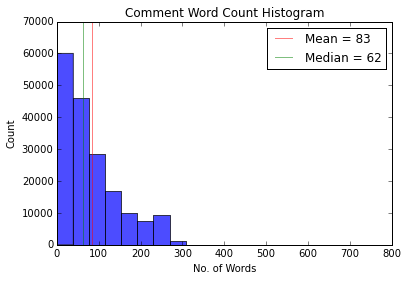

In [75]:
plt.hist(commentsdf["commentLength"], bins=20, alpha = .7)
plt.title("Comment Word Count Histogram")
plt.axvline(82.91,color = 'r',alpha = .5,label = 'Mean = 83')
plt.axvline(62,color = 'g',alpha = .5,label = 'Median = 62')
plt.ylabel("Count")
plt.xlabel("No. of Words")
plt.legend()
plt.show()

In [ ]:
test = commentsdf.groupby(["userID"])
test.commentID.count()
plt.hist(test)

# Final Analysis

In [1]:
test = "hi my name is andrew"

In [2]:
test

'hi my name is andrew'

In [11]:
count = 1
for i in test:
    if i == " ":
        count +=1
count

5

In [12]:
test

'hi my name is andrew'